In [1]:
import warnings
import math
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import math
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from fbprophet import plot
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [3]:
# http://www.tbacking.com/?p=449

In [4]:
test = pd.read_csv('data/test.csv')
feature = pd.read_csv('data/features.csv')
train = pd.read_csv('data/train.csv')

In [5]:
merged = train.merge(feature, how='left', on=['Store','Date'])
merged['Date'] = pd.to_datetime(merged['Date'])
merged['week'] = merged['Date'].dt.week
xdf = merged[(merged['Store']==1)&(merged['Dept']==1)][['week','Temperature','Fuel_Price','Weekly_Sales']]

In [6]:
df = pd.read_csv('data/timedata.csv')

In [7]:
isna = df.T.isnull().sum(axis=0) # 누락값이 있는 데이터와 없는 데이터를 분류
df_isna = df.loc[isna[isna>0].index]
df_nona = df.loc[isna[isna==0].index]#.reset_index(drop=True)
df_sd = df_nona.T.reset_index()[:2]
df_sd = df_sd.T.iloc[1:].rename(columns={0:'s',1:'d'})

df_sdn = df_isna.T.reset_index()[:2]
df_sdn = df_sdn.T.iloc[1:].rename(columns={0:'s',1:'d'})


df_td = df_nona.T.reset_index()[2:]
df_td['index'] = pd.to_datetime(df_td['index'])
df_td = df_td.rename(columns={'index':'Date'})
df_td.insert(0, 'week', df_td['Date'].dt.week)
df_td.insert(0, 'month', df_td['Date'].dt.month)
df_td.insert(0, 'year', df_td['Date'].dt.year)

df_tdn = df_isna.T.reset_index()[2:]
df_tdn['index'] = pd.to_datetime(df_tdn['index'])
df_tdn = df_tdn.rename(columns={'index':'Date'})
df_tdn.insert(0, 'week', df_tdn['Date'].dt.week)
df_tdn.insert(0, 'month', df_tdn['Date'].dt.month)
df_tdn.insert(0, 'year', df_tdn['Date'].dt.year)

In [13]:
nas = df_tdn.drop(columns=['year','month','week','Date']).isna().sum(axis=0).sort_values(ascending=False)

In [23]:
nas[(nas>110)&()]

1027    142
2679    142
908     142
1295    142
3170    142
1332    142
1340    142
362     142
512     142
2240    142
529     142
3101    142
2028    142
1576    142
1604    142
2563    142
738     142
2684    142
211     142
1683    142
216     142
2842    142
2698    142
1760    142
2811    142
264     142
2717    142
1912    142
1219    142
2222    142
       ... 
1194    121
2475    121
3216    120
274     120
2035    120
3038    120
3154    120
376     120
1418    119
2461    119
1031    119
799     118
1107    118
3106    118
3297    118
2694    117
2445    117
1416    116
1113    115
3116    115
1879    114
1496    113
1370    113
803     113
2817    113
2737    112
2801    112
3218    111
2809    111
2243    111
Length: 287, dtype: int64

In [15]:
sdn = 1961
tmp = df_tdn[['Date',sdn]].rename(columns={'Date':'ds', sdn:'y'})
tmpr = mypred(tmp)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


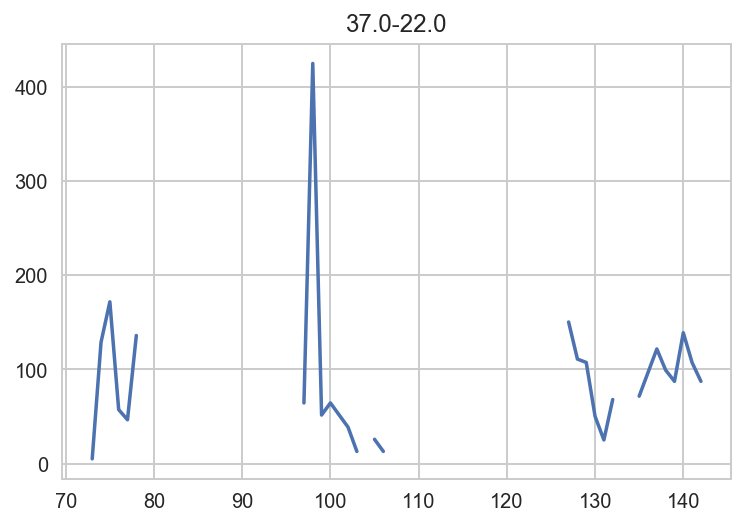

In [24]:
sdn = 2737
v1 = df.loc[sdn][2:]
plt.plot(v1.values)
plt.title('{}-{}'.format(df.loc[sdn]['Store'], df.loc[sdn]['Dept']))
v1 = v1[v1.notna()]
v1idx = v1.index
v1 = v1.values

In [25]:
res = []
for i in tqdm_notebook(df_nona.index):
    row = df_nona.loc[i]
    s = row['Store']
    d = row['Dept']
    v2 = row[2:]
    
    v2 = v2.loc[v1idx].values 
    
    cos = 1 - sp.spatial.distance.cosine(v1, v2)
    res.append([i, s, d, cos])

In [26]:
pd.DataFrame(res).sort_values(3, ascending=False).head()

,0,1,2,3
322,382,6.0,6.0,0.901118
1546,1868,25.0,32.0,0.888981
197,232,4.0,6.0,0.884520
2050,2508,34.0,6.0,0.883328
964,1150,16.0,7.0,0.882412


In [31]:
from sklearn.preprocessing import minmax_scale

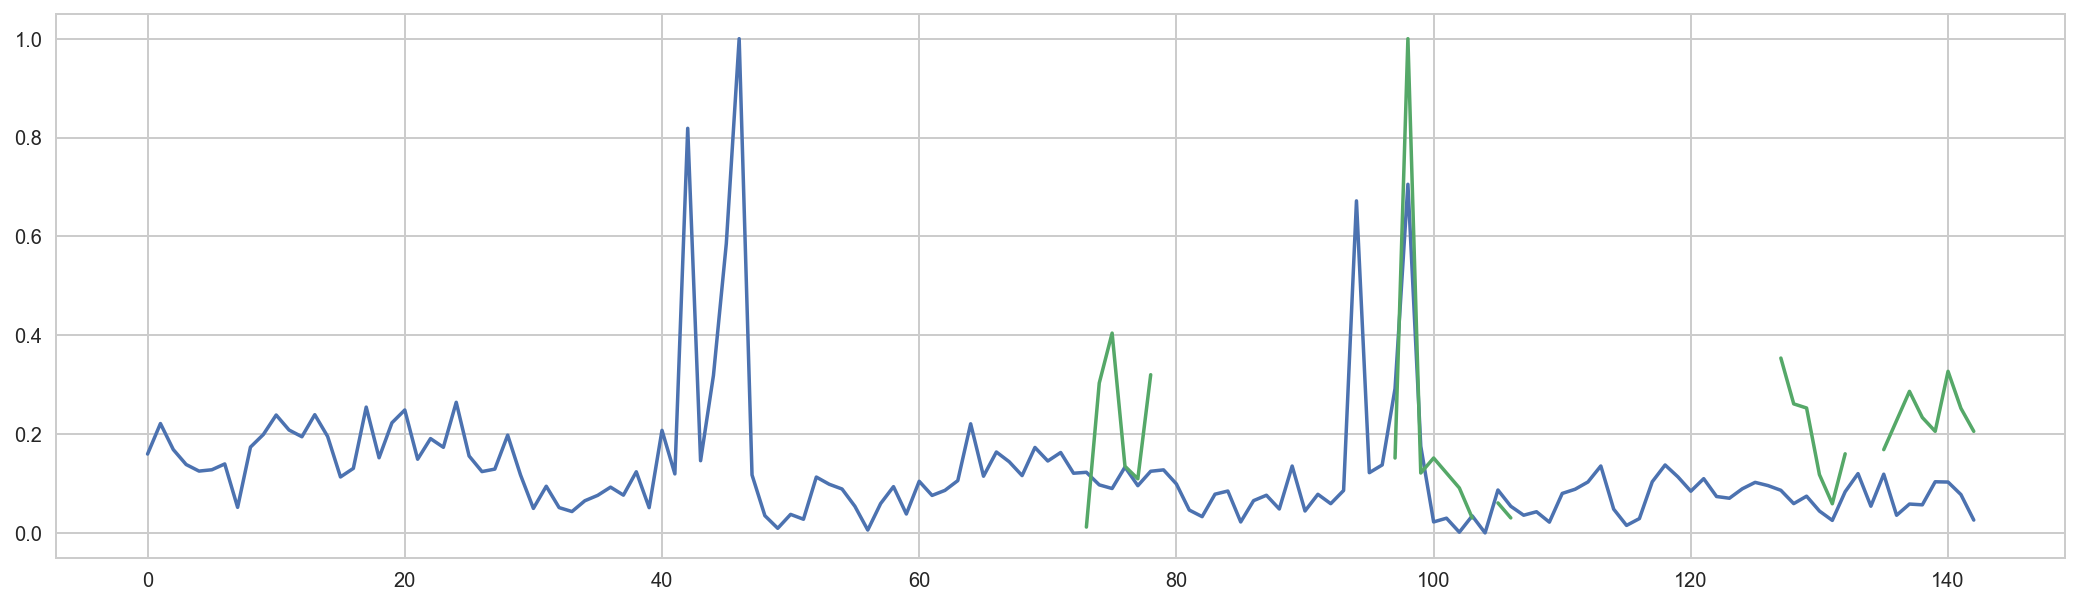

In [48]:
plt.figure(figsize=(18, 5))
plt.plot(minmax_scale(df_nona.loc[382][2:].values))
ov = df.loc[sdn][2:].values 
ov = ov / pd.DataFrame(ov).max()[0]
plt.plot( ov)

In [45]:
pd.DataFrame(ov).max()[0]

425.04

In [8]:
df_test = test.pivot_table('IsHoliday',['Dept','Store'],'Date',aggfunc='count').reset_index()
df_test_sd = df_test[['Dept','Store']]
df_test_td = df_test.drop(columns=['Dept','Store'])

In [9]:
tmp = df_test_td.loc[df_test_td.sum(axis=1)== 39] ## 완전한 데이터
#df_test_td.loc[df_test_td.sum(axis=1)!= 39]

In [11]:
def mypred(tdf): 
    m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)
    m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.fit(tdf)
    future = m.make_future_dataframe(39, freq='w')
    pred = m.predict(future)
    return pred

In [12]:
res = []
errres = []
for i in tqdm_notebook(tmp.index): 

    row = df_test_sd.loc[i]
    s = row['Store']
    d = row['Dept'] 
    
    try:
        idx = df_sd[(df_sd['s']==s)&(df_sd['d']==d)].index[0]
        #print(s, d, idx)
        v = df_td[['Date',idx]].rename(columns={'Date':'ds', idx:'y'})

        pred = mypred(v)
        pred = pred.yhat
        res.append([s, d, pred[-39:]])
    except Exception as e:
        errres.append([i, s, d]) # 추세를 찾지 못한 데이터
        #print(i, s, d)

In [ ]:
## 결측값 처리
## prophet
## xgboost
## lightgbm
## lstm


In [1095]:
sdn = 42
tdf = df_td[['Date',sdn]].rename(columns={'Date':'ds', sdn:'y'})
#tdf['regressor'] = 0

In [1096]:
# m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True, n_changepoints=4, \
#            seasonality_mode = 'multiplicative')
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
#m.add_regressor('regressor')

m.fit(tdf)

future = m.make_future_dataframe(52, freq='w')
future['regressor'] = 0
pred = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


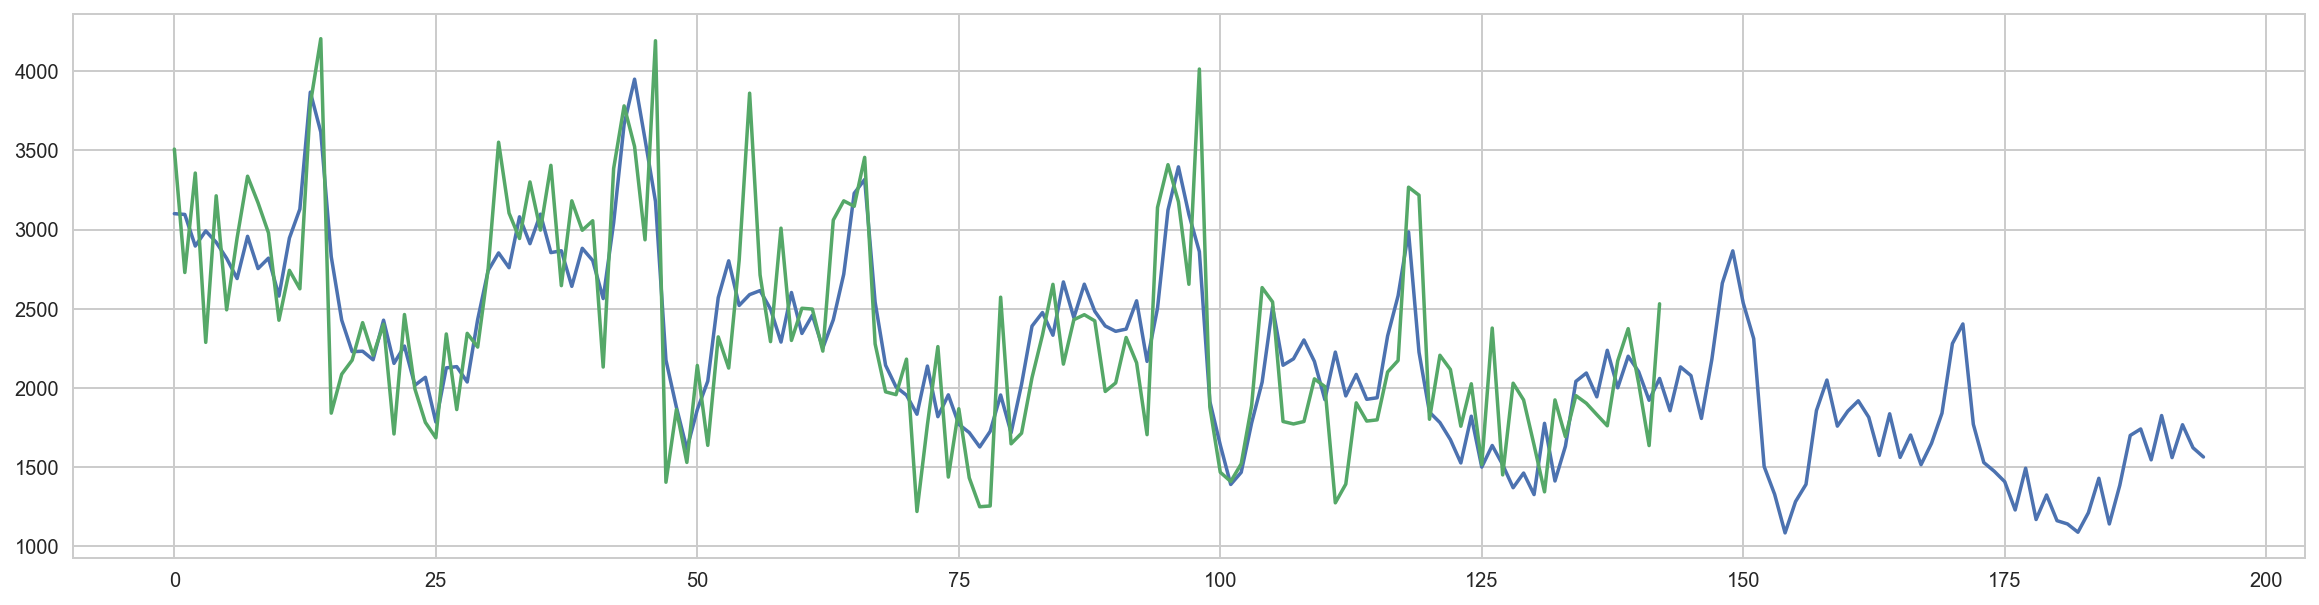

In [1097]:
plt.figure(figsize=(20, 5))
plt.plot(pred.yhat, label=n)
plt.plot(tdf.y.values)
#plt.legend()
plt.show()

In [976]:
np.random.seed(7)

In [977]:
scaler = MinMaxScaler()
nptf = scaler.fit_transform(df_td[42].values.reshape(-1, 1))

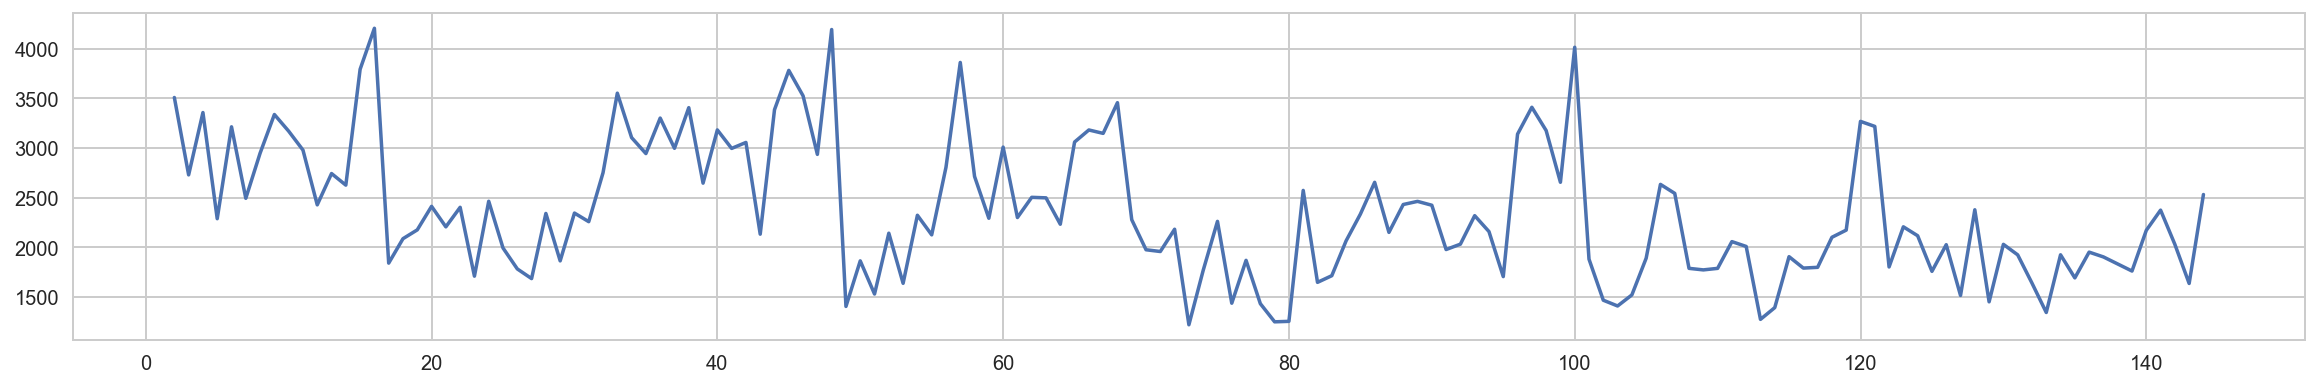

In [987]:
plt.figure(figsize=(20, 3))
plt.plot(df_td[42])

In [988]:
train_size = int(len(nptf) * 0.9)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]

In [989]:
len(train), len(test)

(128, 15)

In [990]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [991]:
look_back = 4
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

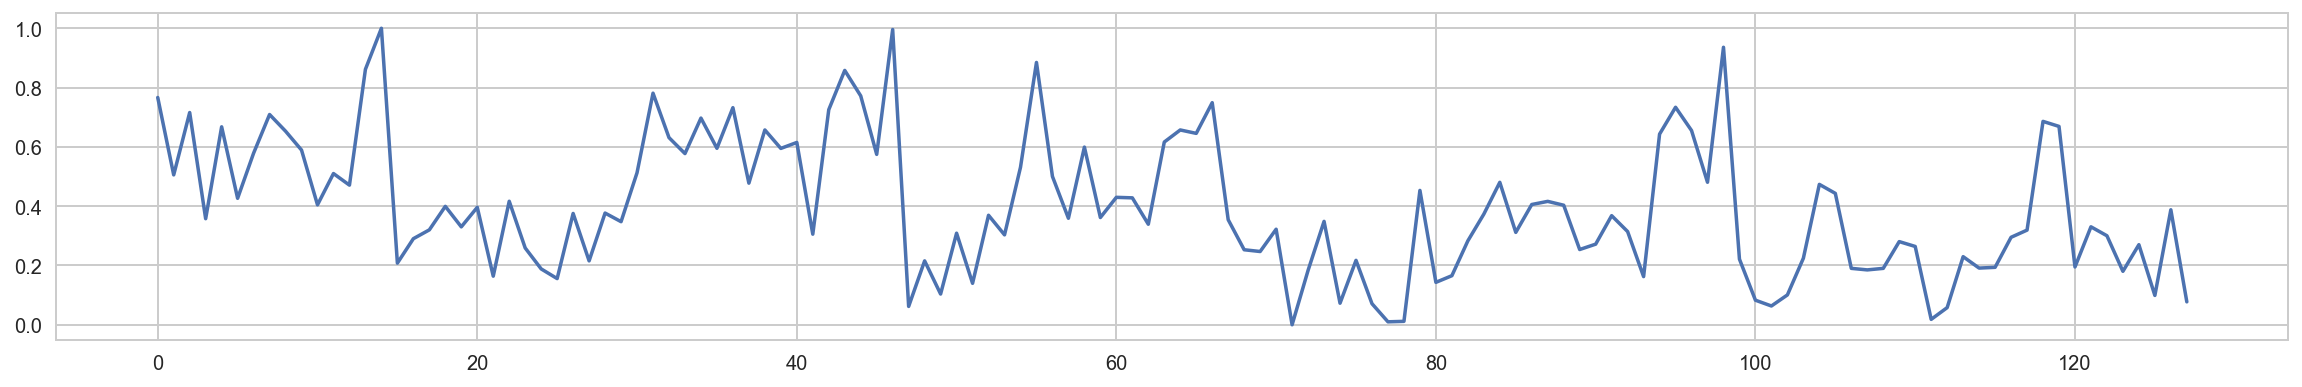

In [994]:
plt.figure(figsize=(20, 3))
plt.plot(train)

In [995]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((124, 4, 1), (124, 1), (11, 4, 1), (11, 1))

In [996]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [997]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((124, 1, 4), (124, 1), (11, 1, 4), (11, 1))

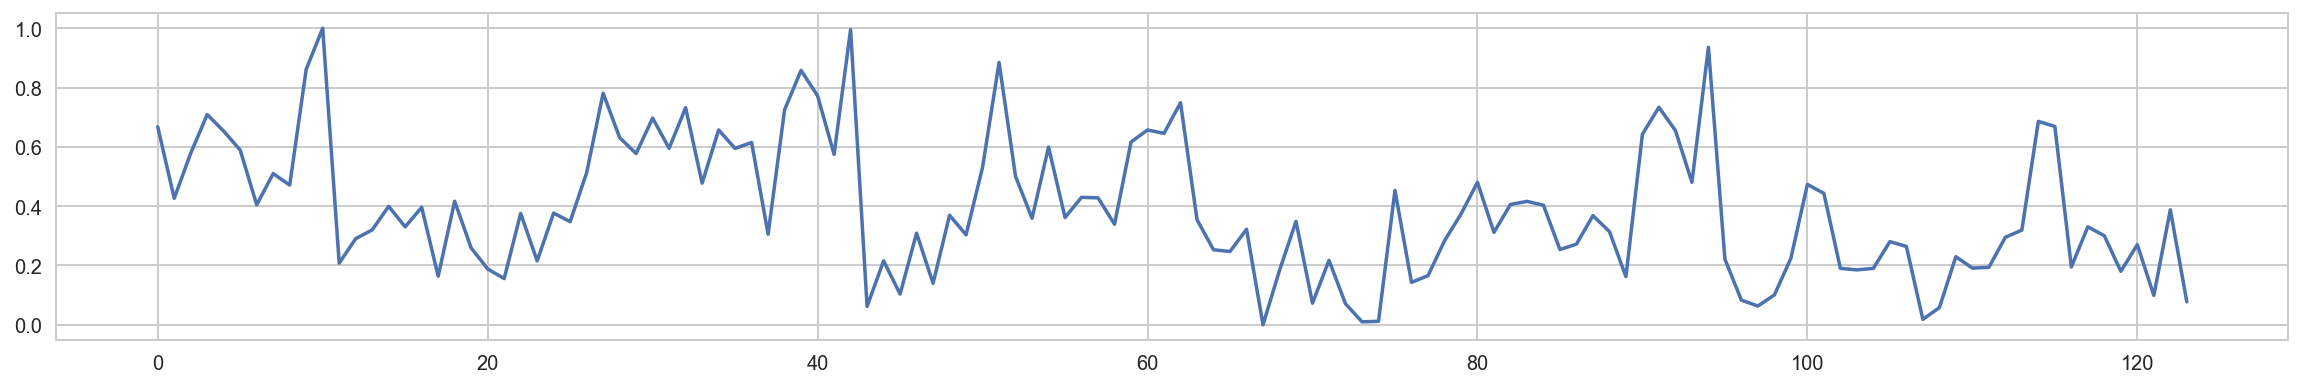

In [1004]:
plt.figure(figsize=(20, 3))
#plt.plot(trainX.ravel())
plt.plot(trainY)

In [999]:
#del model

In [1005]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 4s - loss: 0.1702
Epoch 2/200
 - 0s - loss: 0.0583
Epoch 3/200
 - 0s - loss: 0.0493
Epoch 4/200
 - 0s - loss: 0.0478
Epoch 5/200
 - 0s - loss: 0.0465
Epoch 6/200
 - 0s - loss: 0.0456
Epoch 7/200
 - 1s - loss: 0.0449
Epoch 8/200
 - 0s - loss: 0.0437
Epoch 9/200
 - 0s - loss: 0.0430
Epoch 10/200
 - 0s - loss: 0.0429
Epoch 11/200
 - 0s - loss: 0.0418
Epoch 12/200
 - 1s - loss: 0.0417
Epoch 13/200
 - 1s - loss: 0.0414
Epoch 14/200
 - 1s - loss: 0.0409
Epoch 15/200
 - 0s - loss: 0.0409
Epoch 16/200
 - 1s - loss: 0.0405
Epoch 17/200
 - 0s - loss: 0.0401
Epoch 18/200
 - 1s - loss: 0.0400
Epoch 19/200
 - 0s - loss: 0.0397
Epoch 20/200
 - 0s - loss: 0.0400
Epoch 21/200
 - 0s - loss: 0.0399
Epoch 22/200
 - 0s - loss: 0.0400
Epoch 23/200
 - 0s - loss: 0.0396
Epoch 24/200
 - 0s - loss: 0.0392
Epoch 25/200
 - 0s - loss: 0.0392
Epoch 26/200
 - 0s - loss: 0.0393
Epoch 27/200
 - 0s - loss: 0.0389
Epoch 28/200
 - 0s - loss: 0.0394
Epoch 29/200
 - 0s - loss: 0.0395
Epoch 30/200
 - 0s - lo

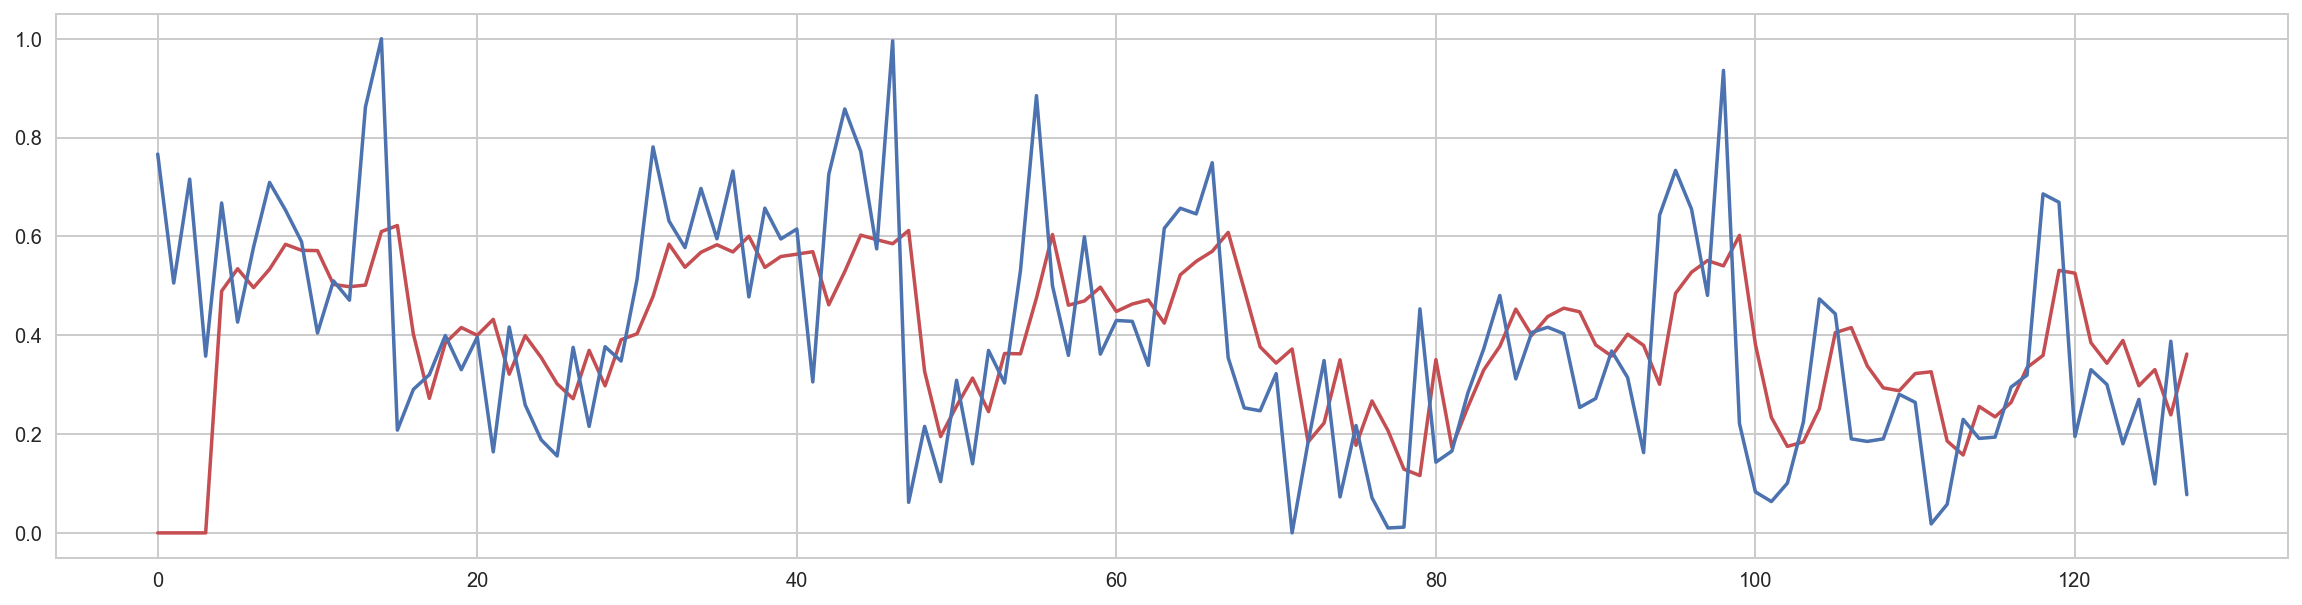

In [1020]:
pred = model.predict(trainX)
#pred = scaler.inverse_transform(pred)
plt.figure(figsize=(20, 5))
plt.plot(np.insert(pred, 0, np.zeros(look_back)), c='r')
plt.plot(train)

In [1007]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 321.97 RMSE


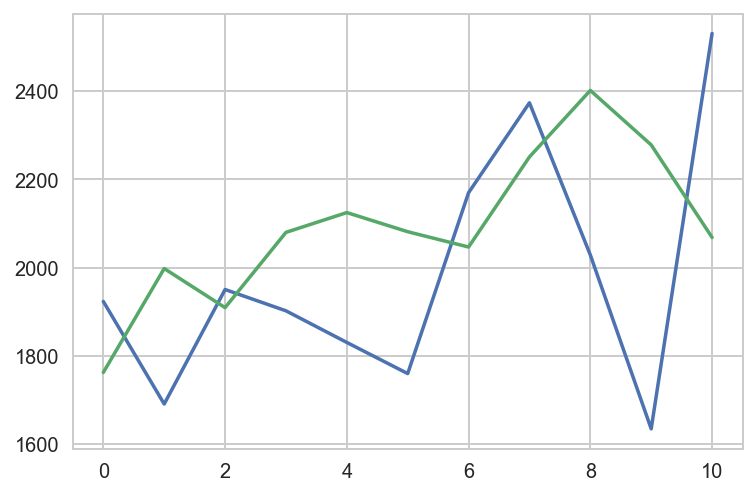

In [1015]:
# plot
plt.plot(testY)
plt.plot(testPredict)
plt.show()

In [1030]:
nptf[-4:]

array([[0.38665845],
       [0.2712029 ],
       [0.13931059],
       [0.43922255]])

In [1027]:
testX.shape

(11, 1, 4)

In [1038]:
# predict last value (or tomorrow?)
lastX = nptf[-4:]
lastX = np.reshape(lastX, (1, 1, -1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측

Predict the Close value of final day: 2411


In [ ]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

In [1040]:
# https://m.blog.naver.com/silvury/220939233742

In [1041]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    # fix random seed for reproducibility
np.random.seed(7)

In [1044]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(df_td[42].values.reshape(-1, 1))

In [1045]:
train_szie = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

In [1046]:
train_szie, test_size

(114, 15)

In [1047]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [1048]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [1049]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((124, 4), (124,), (11, 4), (11,))

In [1050]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [1051]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((124, 1, 4), (124,), (11, 1, 4), (11,))

In [1052]:
del model

In [1053]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=300, batch_size=1, verbose=2)

Epoch 1/300
 - 3s - loss: 0.1433
Epoch 2/300
 - 0s - loss: 0.0591
Epoch 3/300
 - 0s - loss: 0.0434
Epoch 4/300
 - 0s - loss: 0.0430
Epoch 5/300
 - 0s - loss: 0.0426
Epoch 6/300
 - 0s - loss: 0.0420
Epoch 7/300
 - 0s - loss: 0.0414
Epoch 8/300
 - 0s - loss: 0.0414
Epoch 9/300
 - 0s - loss: 0.0412
Epoch 10/300
 - 0s - loss: 0.0408
Epoch 11/300
 - 0s - loss: 0.0403
Epoch 12/300
 - 0s - loss: 0.0400
Epoch 13/300
 - 0s - loss: 0.0401
Epoch 14/300
 - 0s - loss: 0.0399
Epoch 15/300
 - 0s - loss: 0.0395
Epoch 16/300
 - 0s - loss: 0.0395
Epoch 17/300
 - 0s - loss: 0.0396
Epoch 18/300
 - 0s - loss: 0.0393
Epoch 19/300
 - 0s - loss: 0.0391
Epoch 20/300
 - 0s - loss: 0.0390
Epoch 21/300
 - 0s - loss: 0.0391
Epoch 22/300
 - 0s - loss: 0.0395
Epoch 23/300
 - 0s - loss: 0.0388
Epoch 24/300
 - 0s - loss: 0.0390
Epoch 25/300
 - 0s - loss: 0.0388
Epoch 26/300
 - 0s - loss: 0.0390
Epoch 27/300
 - 0s - loss: 0.0388
Epoch 28/300
 - 0s - loss: 0.0386
Epoch 29/300
 - 0s - loss: 0.0388
Epoch 30/300
 - 0s - lo

 - 0s - loss: 0.0358
Epoch 239/300
 - 0s - loss: 0.0366
Epoch 240/300
 - 0s - loss: 0.0359
Epoch 241/300
 - 0s - loss: 0.0357
Epoch 242/300
 - 1s - loss: 0.0358
Epoch 243/300
 - 0s - loss: 0.0357
Epoch 244/300
 - 0s - loss: 0.0357
Epoch 245/300
 - 0s - loss: 0.0358
Epoch 246/300
 - 0s - loss: 0.0357
Epoch 247/300
 - 0s - loss: 0.0358
Epoch 248/300
 - 0s - loss: 0.0357
Epoch 249/300
 - 0s - loss: 0.0357
Epoch 250/300
 - 0s - loss: 0.0357
Epoch 251/300
 - 0s - loss: 0.0357
Epoch 252/300
 - 0s - loss: 0.0357
Epoch 253/300
 - 0s - loss: 0.0355
Epoch 254/300
 - 0s - loss: 0.0358
Epoch 255/300
 - 0s - loss: 0.0355
Epoch 256/300
 - 0s - loss: 0.0356
Epoch 257/300
 - 0s - loss: 0.0355
Epoch 258/300
 - 0s - loss: 0.0359
Epoch 259/300
 - 0s - loss: 0.0356
Epoch 260/300
 - 0s - loss: 0.0358
Epoch 261/300
 - 0s - loss: 0.0355
Epoch 262/300
 - 0s - loss: 0.0356
Epoch 263/300
 - 0s - loss: 0.0357
Epoch 264/300
 - 0s - loss: 0.0359
Epoch 265/300
 - 0s - loss: 0.0358
Epoch 266/300
 - 0s - loss: 0.0354

In [1054]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [1055]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [1056]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 558.31 RMSE
Test Score: 342.70 RMSE


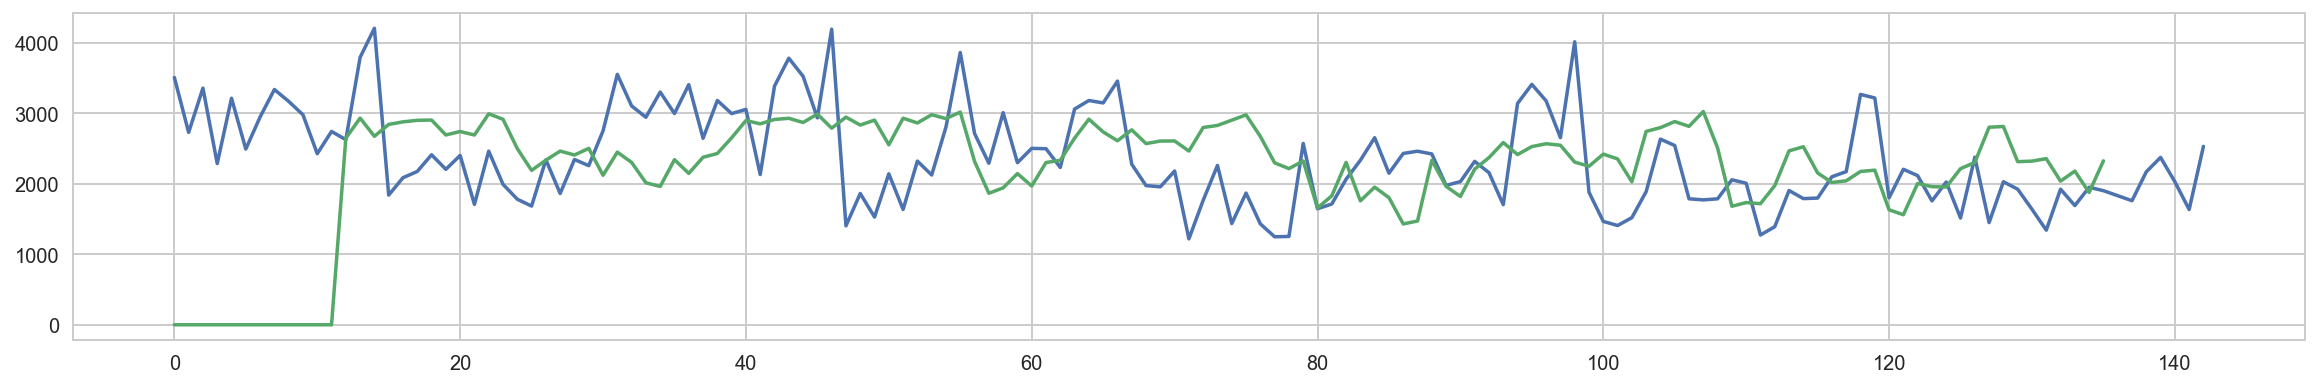

In [1060]:
plt.figure(figsize=(20, 3))
plt.plot(df_td[42].values)
plt.plot(np.insert(trainPredict, 0, np.zeros(12)))

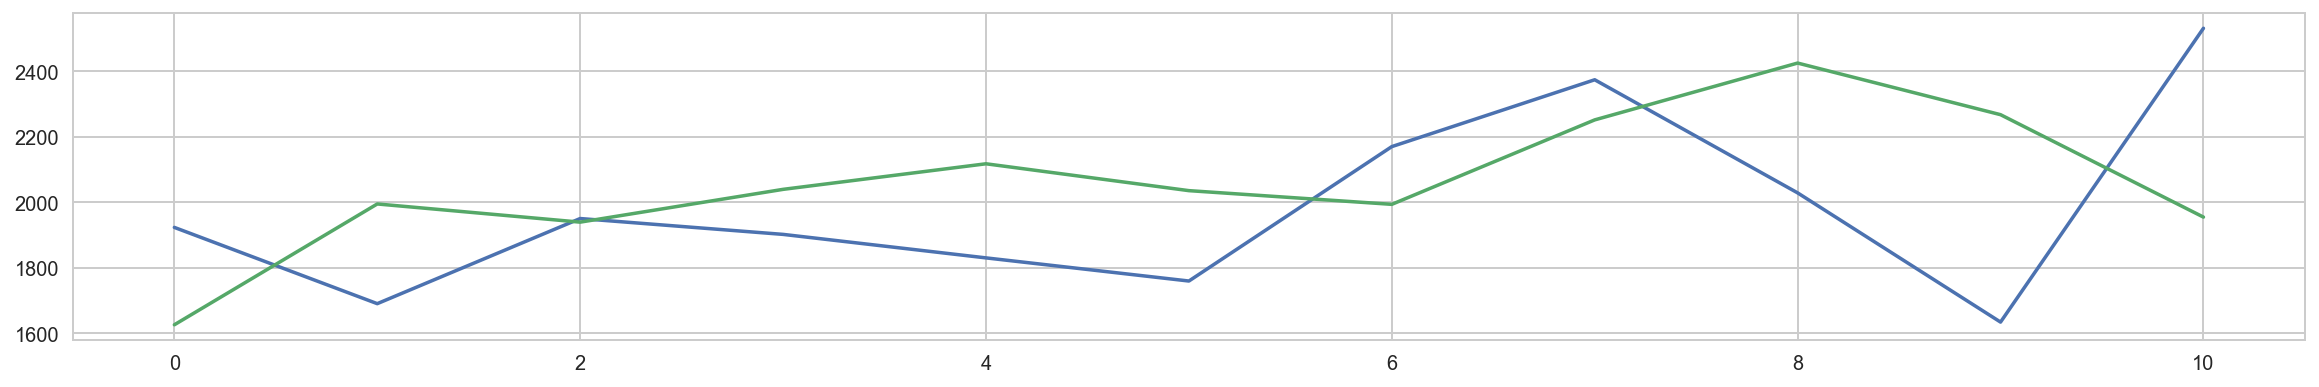

In [1061]:
plt.figure(figsize=(20, 3))
plt.plot(testY.ravel());
plt.plot(testPredict)

In [1067]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [1068]:

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (11,1) into shape (9,1)